A notebook where we synthesize regression models across conditions.  We examine the performance of the models when they are fit together and individually. 

Specifically, we synthesize regression models that predict only one variable.  The models project data down to a single variable, which is then passed through a complicated non-linear function.  When we say we synthesize models "across conditions" we mean that we simulate data so that data for each model projects into a given range of the low-s space, so we only see the behavior of the non-linear function in a certain range for each individual. 

Some details:

1) Each input variable in the model is associated with a 2-d position (position is the measurable property in this example).  Variable positions are sampled uniformly from the unit square. 

2) We pull the weights for each model from a prior where the mean and std. conditioned on position are sums of bump functions (so they are truly smooth). When fitting models, we use hypercube functions for the mean and std. (so there
is model mismatch here).  This can make correctly learning the std functions tricky, because if the true mean functions vary alot within a single hypercube, we will learn a standard deviation that is elevated in that region

3) We simulate data with scales and biases which are very close to 1 and 0, respectively.  This keeps things simpler.  When fitting, we use priors which assume scales and biases are concentrated near these values. 

4) We pull noise variances from a Gamma distribution when simulating data, and we also fit models with priors and posteriors which are also Gamma distributions over noise variances.

In [1]:
%load_ext autoreload
%autoreload 2

In [306]:
import copy
import math

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg
import torch

from janelia_core.math.basic_functions import list_grid_pts
from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.extra_torch_modules import QuadSurf
from janelia_core.ml.utils import list_torch_devices


from probabilistic_model_synthesis.gaussian_nonlinear_regression import compare_weight_prior_dists
from probabilistic_model_synthesis.gaussian_nonlinear_regression import align_low_d_spaces
from probabilistic_model_synthesis.gaussian_nonlinear_regression import fit_with_hypercube_priors
from probabilistic_model_synthesis.gaussian_nonlinear_regression import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_regression import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import GNLRMdl
from probabilistic_model_synthesis.simulation import generate_sum_of_bump_fcns_dist
from probabilistic_model_synthesis.simulation import sample_proj_data_from_interval
from probabilistic_model_synthesis.visualization import assign_colors_to_pts
from probabilistic_model_synthesis.visualization import plot_three_dim_pts

In [145]:
%matplotlib notebook
plt.style.use('dark_background')
matplotlib.rcParams.update({'font.size': 20})

## Parameters go here

In [4]:
# Range of the number of input variables we observe from each individual - the actual number of variables we 
# observe from an individual will be pulled uniformly from this range (inclusive)
n_input_var_range = [5000, 5100]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [12000, 15000]

# ===============================================================================================
# Parameters for the true priors 

# Options for the prior distribution on weights
true_w_prior_opts = {'n_bump_fcns': 50, 'd_in': 2, 'p': 1, 'mn_m_std': 1.0, 'std_m_std': .1, 'bump_w': .2}

# Options for the prior distributions on the scales, biases and psi
true_s_in_prior_opts = {'mn_mn': 1.0/np.sqrt(n_input_var_range[0]), 'mn_std': .00000001, 
                     'std_iv': .00001, 'std_lb': .0000001}

true_s_out_prior_opts = {'mn_mn': 1.0, 'mn_std': .00000001, 
                     'std_iv': .00001, 'std_lb': .0000001}

true_b_prior_opts = {'mn_mn': 0.0, 'mn_std': .00000001, 'std_iv': .001}
true_psi_prior_opts = {'conc_iv': 10.0, 'rate_iv': 1000.0, 'rate_ub': 10000.0}

# ===============================================================================================
# Parameters for the fit models

# The full options for setting up the prior on weights
fit_hc_params = {'n_divisions_per_dim': [20, 20], 
                 'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
                 'n_div_per_hc_side_per_dim': [1, 1]}

# The full options for setting up the prior on weights
fit_w_prior_opts = {'mn_hc_params': fit_hc_params, 'std_hc_params': fit_hc_params, 
                     'min_std': .000001, 'mn_init': 0.0, 'std_init': .3}

# Options for the prior distributions on the scales, biases and psi
fit_s_in_prior_opts = true_s_in_prior_opts
fit_s_out_prior_opts = true_s_out_prior_opts
fit_b_prior_opts = true_b_prior_opts
fit_psi_prior_opts = true_psi_prior_opts

# Options for posterior distribtions 
s_in_post_opts = {'mn_mn': 1.0/np.sqrt(n_input_var_range[0]), 'mn_std': .000001, 
               'std_iv': .00001, 'std_lb': .0000001}
s_out_post_opts = {'mn_mn': 1.0, 'mn_std': .000001, 
               'std_iv': .00001, 'std_lb': .0000001}

b_post_opts = {'mn_mn': 0.0, 'mn_std': .01}
psi_post_opts = {'conc_iv': 10.0, 'rate_iv': 1.0, 'rate_ub': 100000.0}

# Options for the densenet which makes up the shared-m module
dense_net_opts = {'n_layers': 10, 'growth_rate': 5, 'bias': True}

# ======================================================================================================
# Parameters for fitting - should be entered as lists, each entry corresponding to one round of fitting

# Parameters when fitting combined models
comb_sp_fit_opts = [{'n_epochs': 100, 'milestones': None, 'update_int': 100, 'init_lr': .1}]
comb_ip_fit_opts = [{'n_epochs': 5000, 'milestones': [500], 'update_int': 100, 'init_lr': .1}]

single_sp_fit_opts = [{'n_epochs': 100, 'milestones': None, 'update_int': 100, 'init_lr': .1}]
single_ip_fit_opts = [{'n_epochs': 5000, 'milestones': [500], 'update_int': 100, 'init_lr': .1}]


# ======================================================================================================
# Specify the number of intermediate variables and number of variables we predict
p = 1
d_pred = 1


## Create true distributions that govern how systems under study are generated

In [5]:
# Because we do not use the hypercube priors on weights, we provide some default paramaters for these before
# creating the priors

temp_hc_params = {'n_divisions_per_dim': [10, 10], 
                  'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
                   'n_div_per_hc_side_per_dim': [1, 1]}

temp_w_prior_opts = {'mn_hc_params': temp_hc_params, 'std_hc_params': temp_hc_params, 
                     'min_std': .000001, 'mn_init': 0.0, 'std_init': .3}

true_priors = generate_hypercube_prior_collection(p=p, d_pred=d_pred, 
                                                  w_prior_opts=temp_w_prior_opts, 
                                                  s_in_prior_opts=true_s_in_prior_opts, 
                                                  b_in_prior_opts=true_b_prior_opts, 
                                                  s_out_prior_opts=true_s_out_prior_opts,
                                                  b_out_prior_opts=true_b_prior_opts, 
                                                  psi_prior_opts=true_psi_prior_opts)

# We replace the prior over weights 
true_priors.w_prior = generate_sum_of_bump_fcns_dist(**true_w_prior_opts)

## Define the true non-linear function relating projections of input variables to the mean of output variables

In [6]:
class Quad(torch.nn.Module):
    
    def forward(self, x):
        return x + torch.sin(3*x) 

In [7]:
m_true = Quad()

## Generate data

### Generate properties

In [8]:
n_individuals = 4
ind_n_vars = np.random.randint(n_input_var_range[0], n_input_var_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

### Generate true models for each individual

In [9]:
with torch.no_grad():
    ind_true_mdls = [GNLRMdl(m=m_true, 
                     w=true_priors.w_prior.form_standard_sample(true_priors.w_prior.sample(props)),
                     s_in=true_priors.s_in_prior.form_standard_sample(true_priors.s_in_prior.sample(props)).squeeze(axis=1),
                     b_in=true_priors.b_in_prior.form_standard_sample(true_priors.b_in_prior.sample(props)).squeeze(axis=1),
                     s_out=true_priors.s_out_prior.form_standard_sample(true_priors.s_out_prior.sample(props)).squeeze(axis=1),
                     b_out=true_priors.b_out_prior.form_standard_sample(true_priors.b_out_prior.sample(props)).squeeze(axis=1),
                     psi=true_priors.psi_prior.form_standard_sample(true_priors.psi_prior.sample(props)).squeeze(axis=1))
                     for props in ind_props]
    
    if d_pred > 1:
        for mdl in ind_true_mdls:
            mdl.s_out.data = mdl.s_out.data.squeeze()
            mdl.b_out.data = mdl.b_out.data.squeeze()
            mdl.psi.data = mdl.psi.data.squeeze()
                             

### Generate observations from true models

In [10]:
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_data = [None]*n_individuals

intervals = 1.96*np.sqrt(n_input_var_range[0])*np.linspace(-1, 1, n_individuals+1)

for i in range(n_individuals):
    x_i = torch.tensor(sample_proj_data_from_interval(n_smps=ind_n_smps[i], 
                                                      w=ind_true_mdls[i].w.detach().numpy(), 
                                                      interval=[intervals[i], intervals[i+1]]),
                       dtype=torch.float)
    with torch.no_grad():
        y_i = ind_true_mdls[i].sample(x=x_i)
    ind_data[i] = (x_i, y_i)
    
    print('Done generating data for individual ' + str(i) + '.')
    

Done generating data for individual 0.
Done generating data for individual 1.
Done generating data for individual 2.
Done generating data for individual 3.


## Synthesize models (fit models to the data together)

In [15]:
comb_fit_rs = fit_with_hypercube_priors(data=ind_data, props=ind_props, p=p, 
                                   w_prior_opts=fit_w_prior_opts, 
                                   s_in_prior_opts=fit_s_in_prior_opts,
                                   b_in_prior_opts=fit_b_prior_opts,
                                   s_out_prior_opts=fit_s_out_prior_opts,
                                   b_out_prior_opts=fit_b_prior_opts,
                                   psi_prior_opts=fit_psi_prior_opts,
                                   s_in_post_opts=s_in_post_opts,
                                   b_in_post_opts=b_post_opts,
                                   s_out_post_opts=s_out_post_opts,
                                   b_out_post_opts=b_post_opts,
                                   psi_post_opts=psi_post_opts,
                                   dense_net_opts=dense_net_opts, 
                                   sp_fit_opts=comb_sp_fit_opts, 
                                   ip_fit_opts=comb_ip_fit_opts)
                        

Found 1 GPUs
Beginning SP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 2.03e+08
----------------------------------------
NELL: 2.77e+04, 3.00e+04, 2.77e+04, 2.39e+04
W KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
S_in KL: 2.53e+07, 2.53e+07, 2.53e+07, 2.53e+07
B_in KL: 2.19e+03, 2.25e+03, 1.97e+03, 1.95e+03
S_out KL: 2.53e+07, 2.53e+07, 2.53e+07, 2.53e+07
B_out KL: 2.32e+03, 2.09e+03, 2.20e+03, 2.47e+03
Psi KL: 7.78e+03, 7.78e+03, 7.78e+03, 7.78e+03
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.41617679595947266
----------------------------------------
CPU cur memory used (GB): 3.55e+00
GPU_0 cur memory used (GB): 9.70e-01, max memory used (GB): 9.70e-01
Beginning IP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 2.15e+08
----------------------------------------
NELL: 3.21e+06, 3.97e+05, 6.63e+04, 6.99e+06
W KL: 3.26e+05, 3.36e+05, 3.37e+05, 3.41e+05
S_in KL: 2.53e+07, 2.53e+07, 2.54e+07, 2.53e+07
B_in KL: 2.35e+03, 1.53e+03, 1.28e+03, 3.33e+


=========== EPOCH 1200 COMPLETE ===========
Obj: 5.62e+03
----------------------------------------
NELL: -3.72e+03, -6.49e+03, -6.91e+03, -3.57e+02
W KL: 4.13e+03, 7.69e+03, 8.09e+03, 2.25e+03
S_in KL: 5.57e+01, 6.27e+00, 4.15e+01, 9.75e-02
B_in KL: 2.38e+02, 1.11e+02, 1.09e+02, 2.40e+02
S_out KL: 7.20e-05, 3.83e-02, 1.75e-02, 1.17e-04
B_out KL: 1.53e+01, 7.45e+01, 2.01e+01, 2.95e+01
Psi KL: 1.38e-01, 7.46e-01, 1.42e+00, 4.88e-01
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 161.44821071624756
----------------------------------------
CPU cur memory used (GB): 4.52e+00
GPU_0 cur memory used (GB): 9.71e-01, max memory used (GB): 9.71e-01

=========== EPOCH 1300 COMPLETE ===========
Obj: 5.63e+03
----------------------------------------
NELL: -3.33e+03, -7.00e+03, -7.02e+03, -1.02e+03
W KL: 4.79e+03, 7.78e+03, 8.15e+03, 2.27e+03
S_in KL: 2.44e+01, 1.59e+01, 1.34e+01, 6.54e+01
B_in KL: 2.71e+02, 8.58e+01, 9.48e+01, 2.67e+02
S_out KL: 1.44e-03, 1.80


=========== EPOCH 2400 COMPLETE ===========
Obj: 1.89e+03
----------------------------------------
NELL: -3.31e+03, -8.72e+03, -8.03e+03, -3.53e+03
W KL: 3.80e+03, 8.51e+03, 8.62e+03, 3.65e+03
S_in KL: 4.07e+01, 9.86e+00, 1.11e+02, 1.26e+01
B_in KL: 2.01e+02, 9.26e+01, 1.03e+02, 1.92e+02
S_out KL: 2.66e-02, 4.76e-02, 1.44e-02, 2.25e-04
B_out KL: 1.49e+01, 4.47e+01, 5.06e+01, 2.35e+01
Psi KL: 4.51e-01, 1.24e+00, 1.67e+00, 2.96e-01
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 321.4206576347351
----------------------------------------
CPU cur memory used (GB): 4.52e+00
GPU_0 cur memory used (GB): 9.71e-01, max memory used (GB): 9.71e-01

=========== EPOCH 2500 COMPLETE ===========
Obj: 2.57e+04
----------------------------------------
NELL: -1.29e+03, -8.57e+03, -7.68e+03, -3.36e+03
W KL: 5.17e+03, 8.63e+03, 8.67e+03, 3.97e+03
S_in KL: 1.91e+04, 1.24e+02, 2.15e+01, 2.31e+02
B_in KL: 1.67e+02, 7.51e+01, 1.18e+02, 2.08e+02
S_out KL: 4.63e-02, 1.58e


=========== EPOCH 3600 COMPLETE ===========
Obj: 4.53e+02
----------------------------------------
NELL: -5.68e+03, -9.26e+03, -8.24e+03, -4.81e+03
W KL: 5.40e+03, 8.73e+03, 8.65e+03, 4.43e+03
S_in KL: 2.03e+02, 1.01e+01, 6.86e+01, 2.66e+02
B_in KL: 1.34e+02, 1.36e+02, 1.07e+02, 1.01e+02
S_out KL: 5.76e-01, 1.46e+01, 4.75e+01, 2.38e+00
B_out KL: 1.07e+01, 4.10e+01, 4.98e+01, 2.32e+01
Psi KL: 3.18e-01, 1.41e+00, 1.41e+00, 3.85e-01
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 480.57694959640503
----------------------------------------
CPU cur memory used (GB): 4.52e+00
GPU_0 cur memory used (GB): 9.71e-01, max memory used (GB): 9.71e-01

=========== EPOCH 3700 COMPLETE ===========
Obj: 5.64e+03
----------------------------------------
NELL: -4.79e+03, -9.03e+03, -7.76e+03, -4.79e+03
W KL: 5.35e+03, 8.79e+03, 8.61e+03, 4.19e+03
S_in KL: 5.21e+02, 3.98e+02, 1.31e+03, 1.03e+02
B_in KL: 1.33e+02, 1.01e+02, 1.07e+02, 1.80e+02
S_out KL: 4.55e+01, 3.63


=========== EPOCH 4800 COMPLETE ===========
Obj: 2.62e+03
----------------------------------------
NELL: -5.90e+03, -9.46e+03, -8.54e+03, -5.46e+03
W KL: 5.59e+03, 8.91e+03, 8.86e+03, 4.86e+03
S_in KL: 1.99e+02, 2.82e+02, 9.19e+01, 3.03e+02
B_in KL: 1.04e+02, 1.29e+02, 1.22e+02, 1.27e+02
S_out KL: 6.01e-01, 4.69e+01, 2.16e+03, 3.04e+01
B_out KL: 1.86e+01, 6.18e+01, 7.82e+01, 1.81e+01
Psi KL: 4.18e-01, 1.59e+00, 1.47e+00, 4.86e-01
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 642.1585831642151
----------------------------------------
CPU cur memory used (GB): 4.52e+00
GPU_0 cur memory used (GB): 9.71e-01, max memory used (GB): 9.71e-01

=========== EPOCH 4900 COMPLETE ===========
Obj: 2.14e+02
----------------------------------------
NELL: -5.39e+03, -9.20e+03, -8.43e+03, -6.59e+03
W KL: 5.11e+03, 8.93e+03, 8.79e+03, 5.55e+03
S_in KL: 3.25e+01, 4.64e+02, 2.22e+02, 4.57e+01
B_in KL: 1.20e+02, 1.17e+02, 1.13e+02, 9.52e+01
S_out KL: 2.94e+01, 4.00e

## Fit a model to one example individual

In [16]:
single_fit_ind = 0

In [17]:
single_fit_rs = fit_with_hypercube_priors(data=[ind_data[single_fit_ind]], 
                                          props=[ind_props[single_fit_ind]], p=p, 
                                          w_prior_opts=fit_w_prior_opts, 
                                          s_in_prior_opts=fit_s_in_prior_opts,
                                          b_in_prior_opts=fit_b_prior_opts,
                                          s_out_prior_opts=fit_s_out_prior_opts,
                                          b_out_prior_opts=fit_b_prior_opts,
                                          psi_prior_opts=fit_psi_prior_opts,
                                          s_in_post_opts=s_in_post_opts,
                                          b_in_post_opts=b_post_opts,
                                          s_out_post_opts=s_out_post_opts,
                                          b_out_post_opts=b_post_opts,
                                          psi_post_opts=psi_post_opts,
                                          dense_net_opts=dense_net_opts, 
                                          sp_fit_opts=single_sp_fit_opts, 
                                          ip_fit_opts=single_ip_fit_opts)

Found 1 GPUs
Beginning SP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 5.07e+07
----------------------------------------
NELL: 5.23e+04
W KL: 0.00e+00
S_in KL: 2.53e+07
B_in KL: 1.79e+03
S_out KL: 2.53e+07
B_out KL: 2.19e+03
Psi KL: 7.78e+03
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.035314083099365234
----------------------------------------
CPU cur memory used (GB): 5.48e+00
GPU_0 cur memory used (GB): 2.50e-01, max memory used (GB): 2.50e-01
Beginning IP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 5.08e+07
----------------------------------------
NELL: 1.07e+05
W KL: 7.46e+02
S_in KL: 2.53e+07
B_in KL: 2.47e+03
S_out KL: 2.53e+07
B_out KL: 2.46e+03
Psi KL: 6.24e-01
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.04570436477661133
----------------------------------------
CPU cur memory used (GB): 5.73e+00
GPU_0 cur memory used (GB): 2.51e-01, max memory used (GB): 2.51e-01

=========== EPOCH 100 COMPLETE ====


=========== EPOCH 1700 COMPLETE ===========
Obj: -1.53e+03
----------------------------------------
NELL: -6.99e+03
W KL: 5.43e+03
S_in KL: 3.46e+01
B_in KL: 2.05e-01
S_out KL: 2.15e-02
B_out KL: 4.39e-01
Psi KL: 4.75e-04
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 65.24760389328003
----------------------------------------
CPU cur memory used (GB): 5.73e+00
GPU_0 cur memory used (GB): 2.51e-01, max memory used (GB): 2.51e-01

=========== EPOCH 1800 COMPLETE ===========
Obj: -1.53e+03
----------------------------------------
NELL: -7.13e+03
W KL: 5.57e+03
S_in KL: 2.51e+01
B_in KL: 8.29e-01
S_out KL: 2.00e-02
B_out KL: 3.26e-01
Psi KL: 1.65e-03
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 69.16207599639893
----------------------------------------
CPU cur memory used (GB): 5.73e+00
GPU_0 cur memory used (GB): 2.51e-01, max memory used (GB): 2.51e-01

=========== EPOCH 1900 COMPLETE ===========
Obj: -1.7


=========== EPOCH 3500 COMPLETE ===========
Obj: -1.72e+03
----------------------------------------
NELL: -6.53e+03
W KL: 4.73e+03
S_in KL: 7.75e+00
B_in KL: 5.31e-01
S_out KL: 7.17e+01
B_out KL: 2.20e-01
Psi KL: 2.78e-02
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 133.9087312221527
----------------------------------------
CPU cur memory used (GB): 5.73e+00
GPU_0 cur memory used (GB): 2.51e-01, max memory used (GB): 2.51e-01

=========== EPOCH 3600 COMPLETE ===========
Obj: -5.33e+02
----------------------------------------
NELL: -5.64e+03
W KL: 4.68e+03
S_in KL: 4.18e+02
B_in KL: 5.96e-01
S_out KL: 1.20e+00
B_out KL: 2.92e+00
Psi KL: 1.34e+00
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 137.5693051815033
----------------------------------------
CPU cur memory used (GB): 5.73e+00
GPU_0 cur memory used (GB): 2.51e-01, max memory used (GB): 2.51e-01

=========== EPOCH 3700 COMPLETE ===========
Obj: 2.24

## Plot some example data

In [43]:
# Helper formatting function
def format_box(ax):
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.xlabel('property dim 1 (a.u.)')
    plt.ylabel('property dim 2 (a.u.)')

In [238]:
n_plot_vars = 1000 # Number of variables we plot the location of
ex_ind = 0

### Show the location of some example variables in property space

<IPython.core.display.Javascript object>


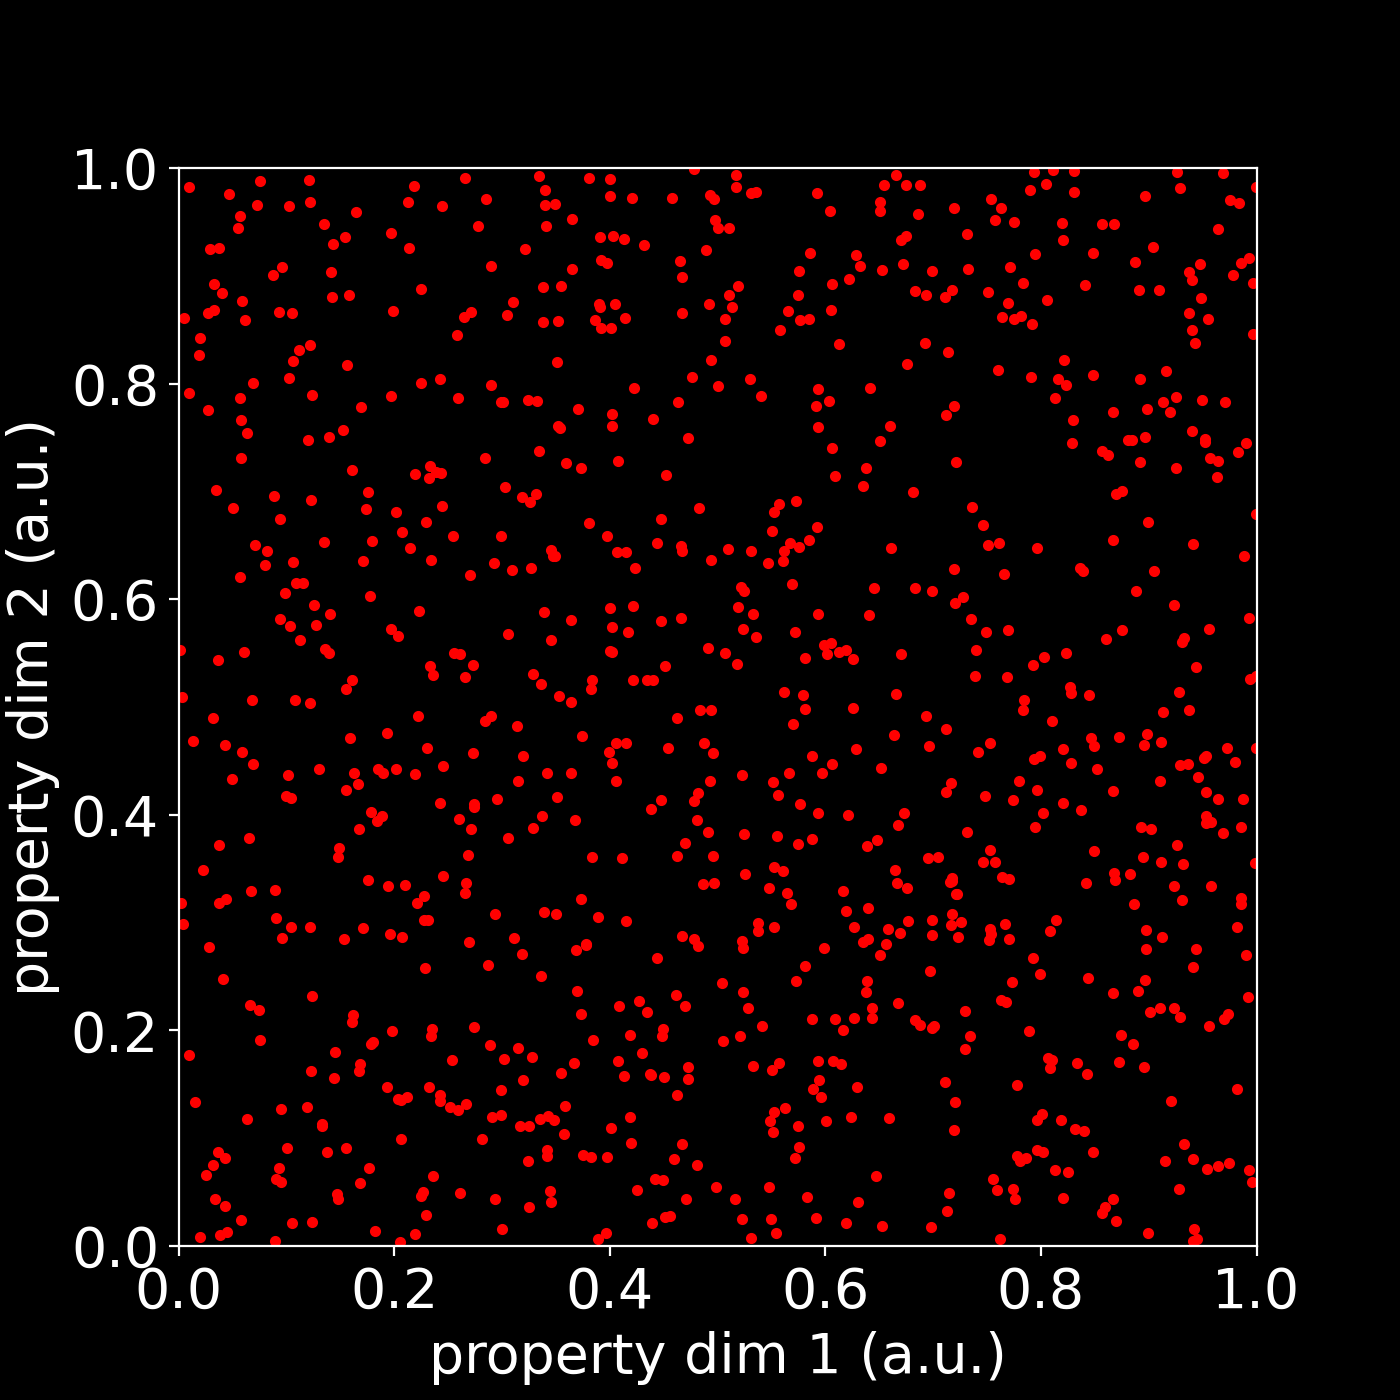

In [239]:
plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
ax.plot(ind_props[ex_ind][0:n_plot_vars,0], ind_props[ex_ind][0:n_plot_vars,1], 'r.')
format_box(ax)

### Plot the mean and standard deviation of the true weight distribution

In [240]:
overlay_pts = True # True if we want to overlay neuron locations on plots

<IPython.core.display.Javascript object>


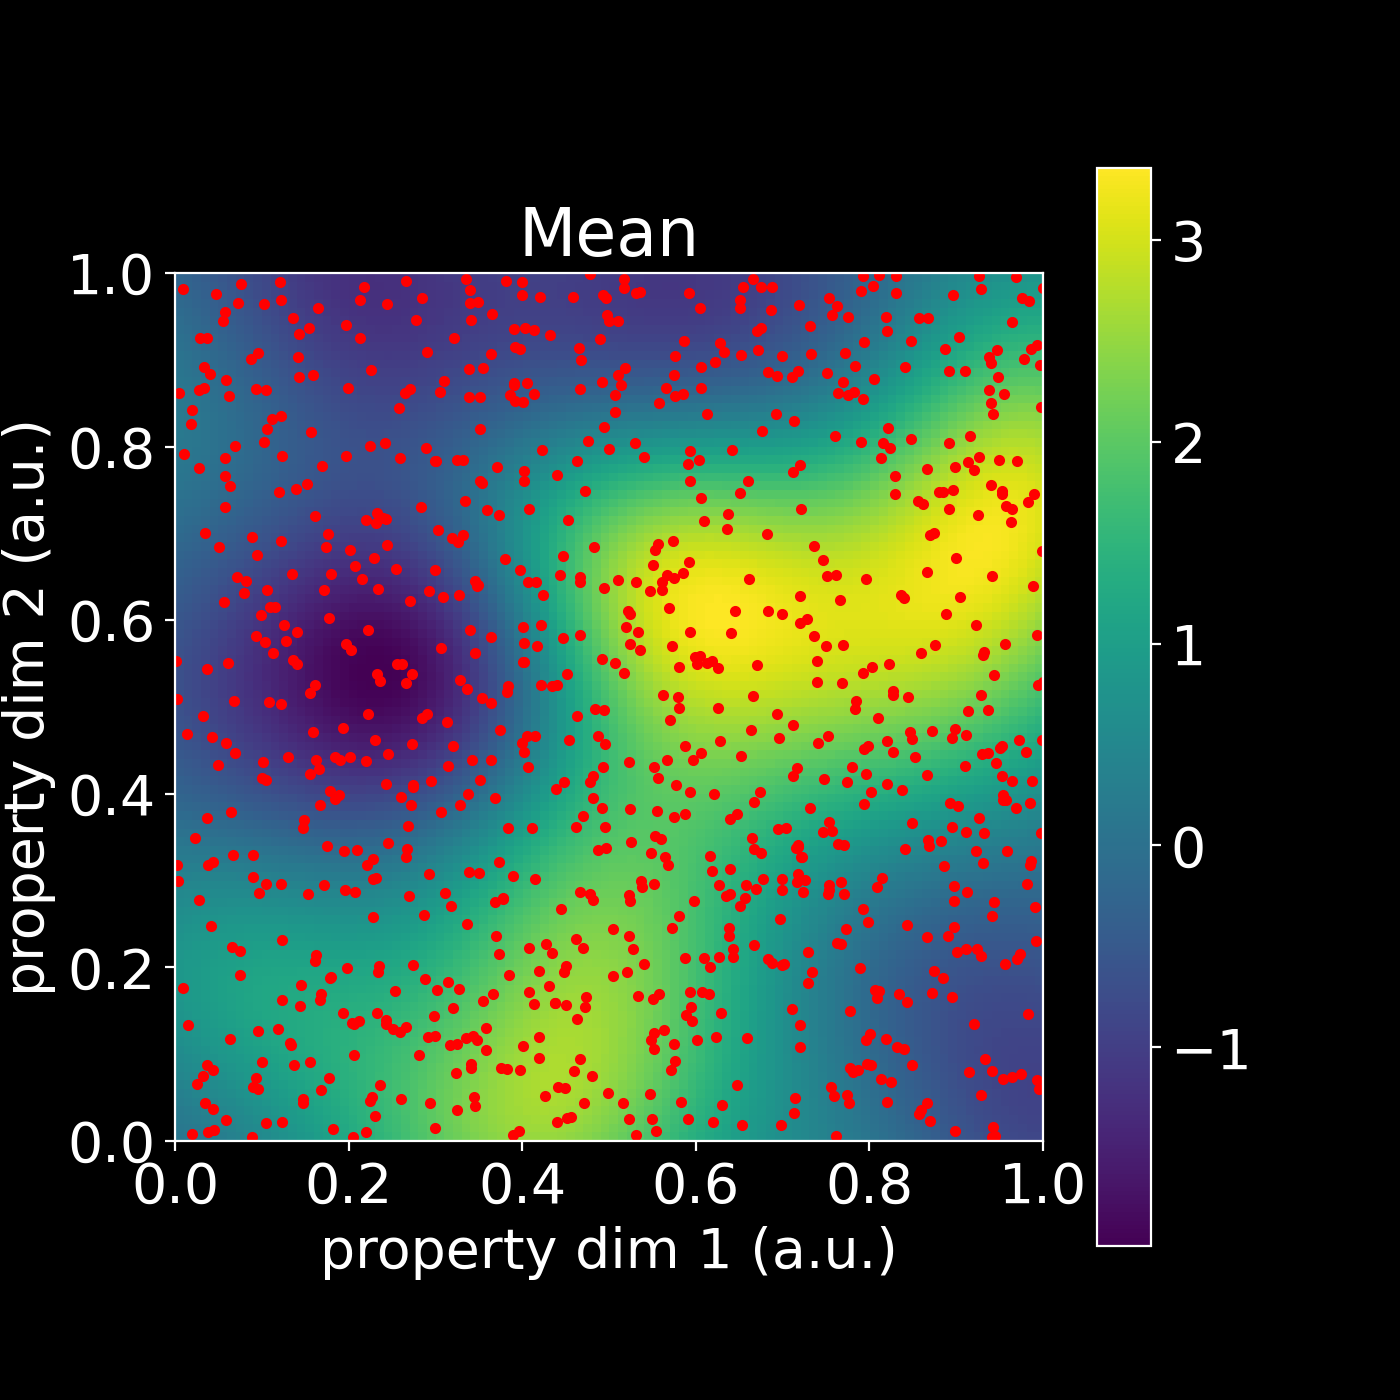

<IPython.core.display.Javascript object>


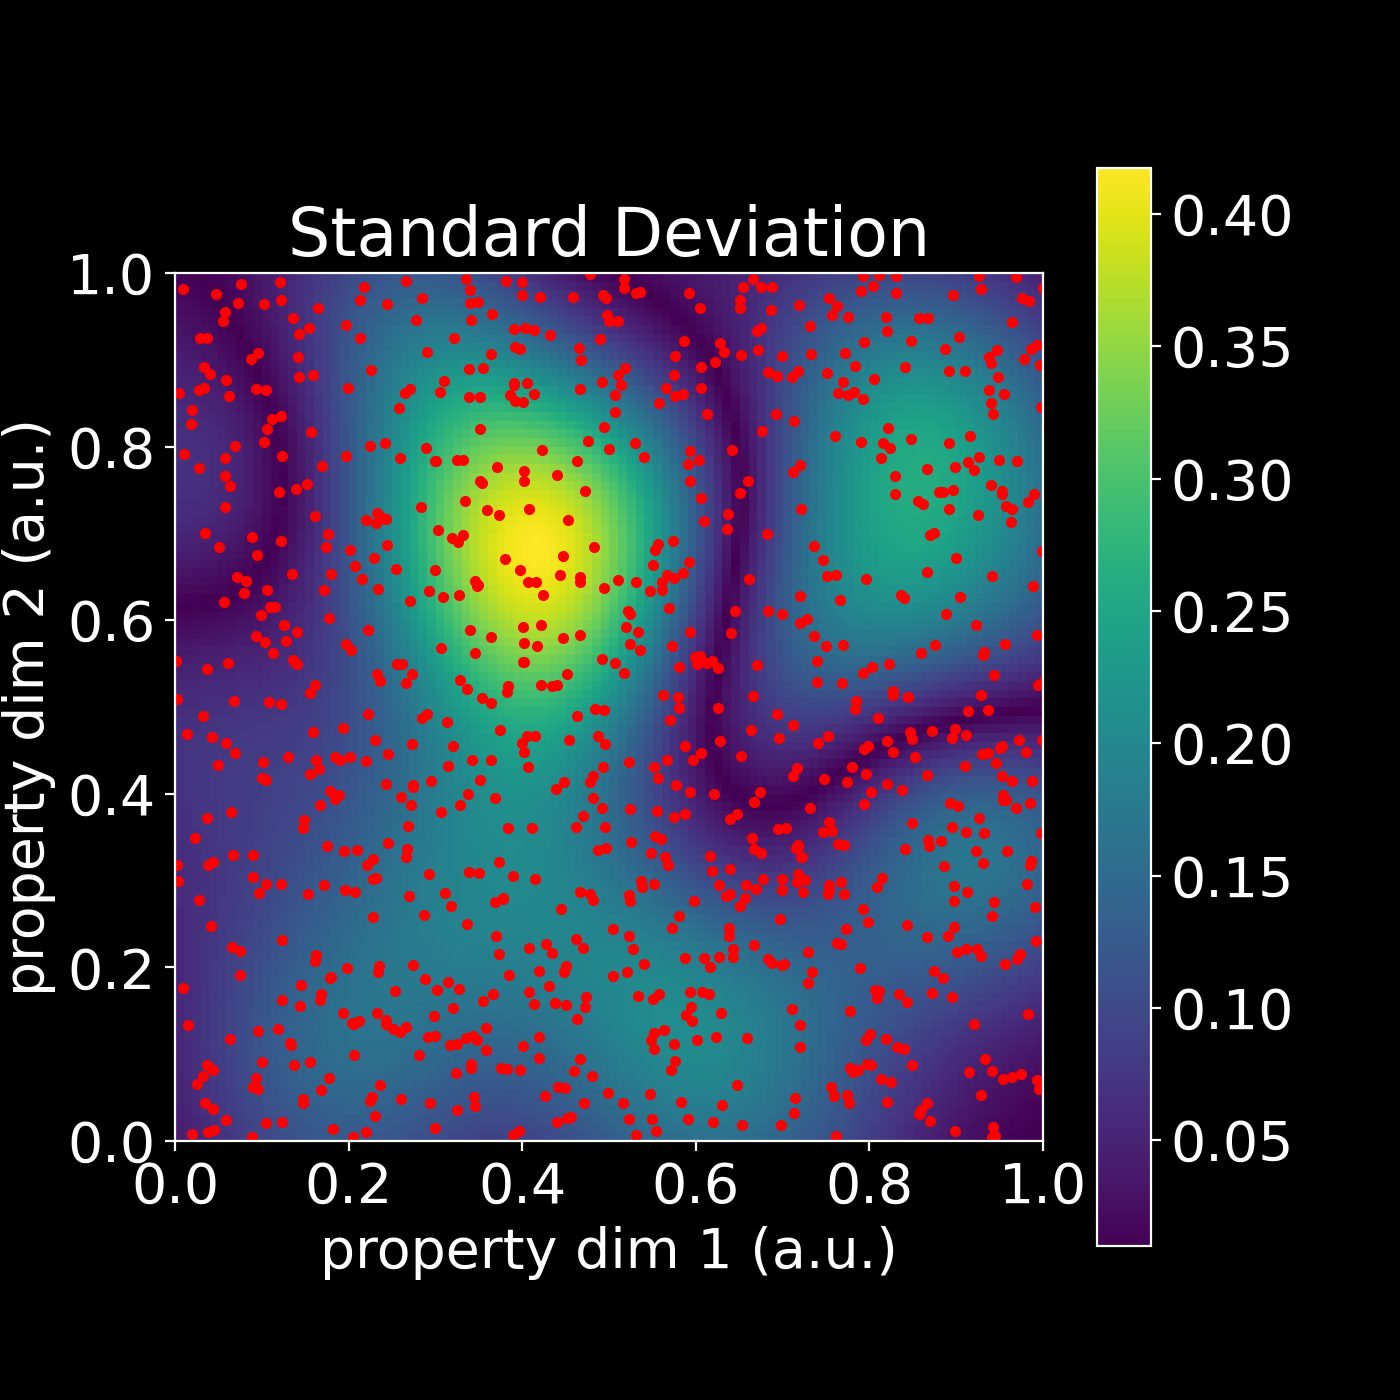

In [241]:
pts, dim_pts = list_grid_pts(grid_limits=np.asarray([[0, 1.0], [0, 1.0]]), n_pts_per_dim=[100,100])
pts = torch.tensor(pts, dtype=torch.float)

true_w_mn = true_priors.w_prior(pts).detach().cpu().numpy()
true_w_std = np.concatenate([d.std_f(pts).detach().cpu().numpy() for d in true_priors.w_prior.dists], axis=1)
true_w_mn = true_w_mn.reshape([100,100]).transpose()
true_w_std = true_w_std.reshape([100,100]).transpose()

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(true_w_mn, origin='lower', extent=[0, 1.0, 0, 1.0])
mn_vmin, mn_vmax = im.get_clim() # Keep track of color limits
plt.colorbar(im)
format_box(ax)
plt.title('Mean')
if overlay_pts:
    ax.plot(ind_props[ex_ind][0:n_plot_vars,0], ind_props[ex_ind][0:n_plot_vars,1], 'r.')

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(true_w_std, origin='lower', extent=[0, 1.0, 0, 1.0])
std_vmin, std_vmax = im.get_clim() # Keep track of color limits
plt.colorbar(im)
format_box(ax)
plt.title('Standard Deviation')
if overlay_pts:
    ax.plot(ind_props[ex_ind][0:n_plot_vars,0], ind_props[ex_ind][0:n_plot_vars,1], 'r.')


### Plot the sampled weights for the example individual

<IPython.core.display.Javascript object>


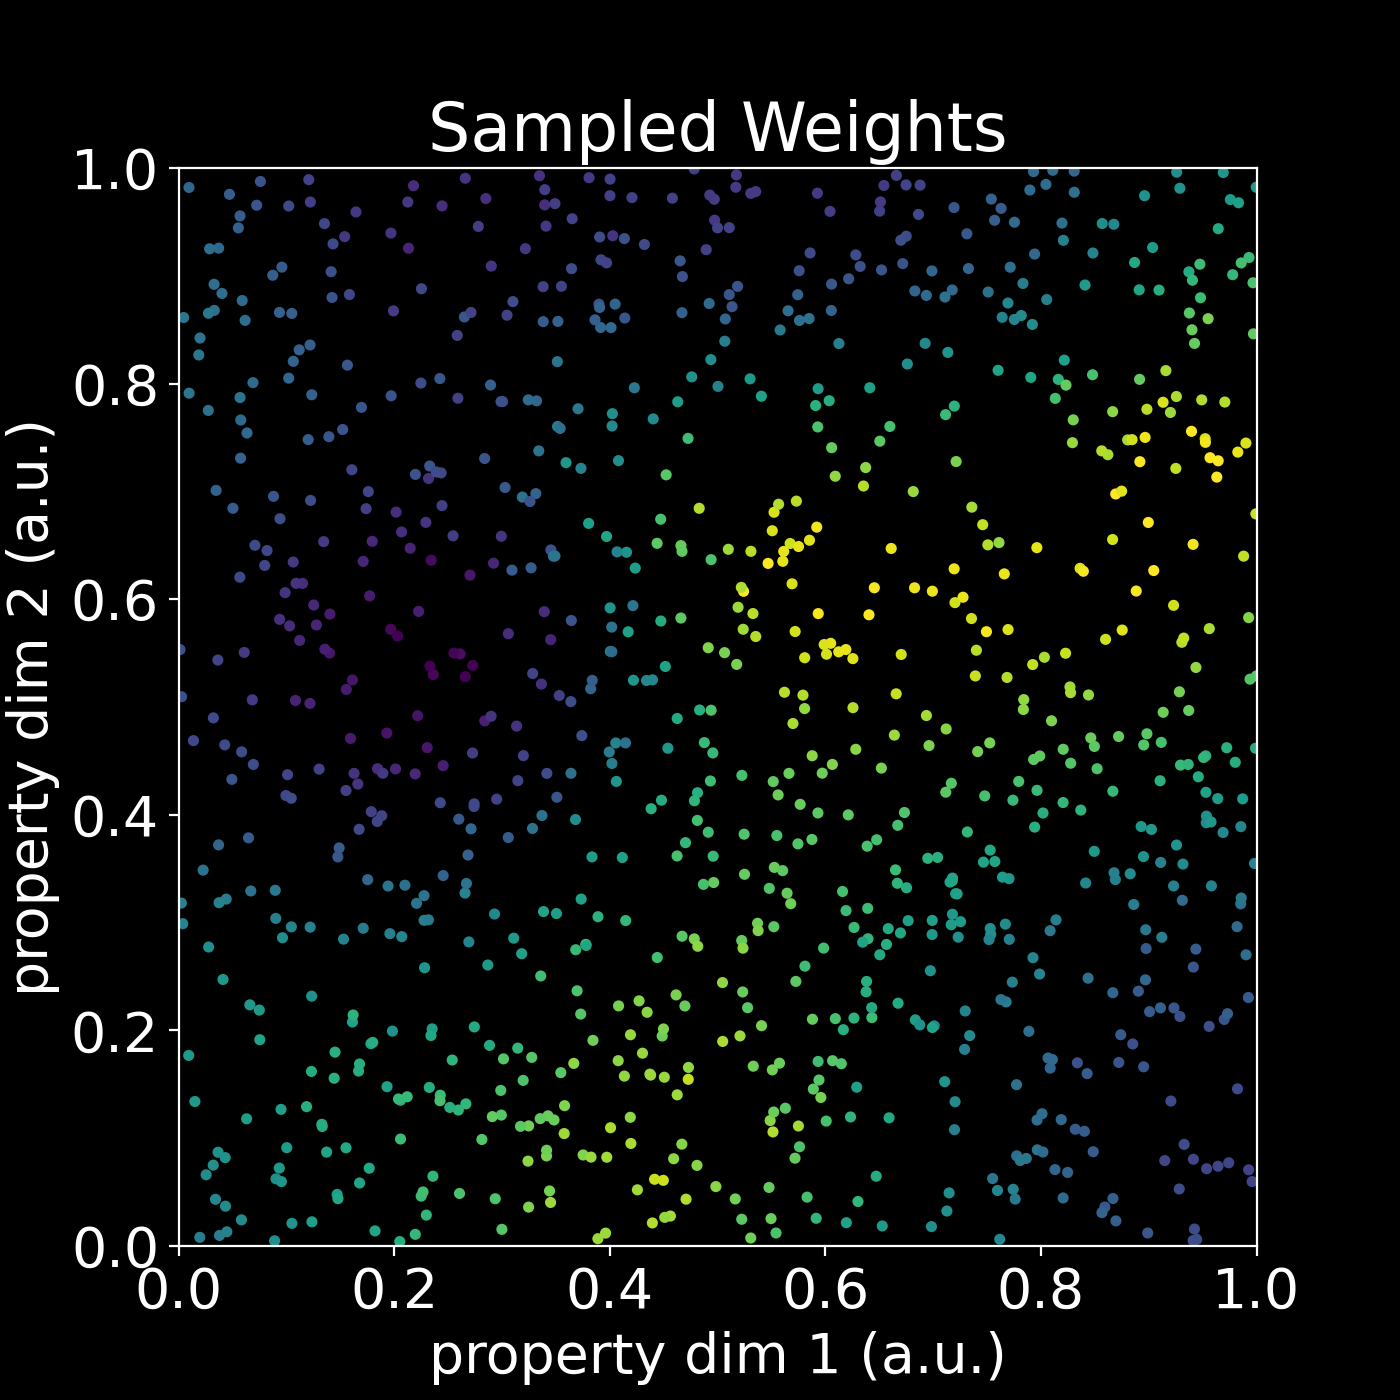

Text(0.5, 1.0, 'Sampled Weights')

In [242]:
plot_w_vls = ind_true_mdls[ex_ind].w.detach().numpy()[0:n_plot_vars]
plow_w_vls_scaled = (plot_w_vls - mn_vmin)/(mn_vmax - mn_vmin)
plot_w_clrs = cm.viridis(plow_w_vls_scaled)

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
ax.scatter(ind_props[ex_ind][0:n_plot_vars,0], ind_props[ex_ind][0:n_plot_vars,1], marker='.', color=plot_w_clrs)
format_box(ax)
plt.title('Sampled Weights')

## Plot the true low-d function and the true data from the example individual

In [243]:
n_plot_smps = 100

In [244]:
f_x_vls = torch.linspace(-2, 2, 100)
true_f_vls = ind_true_mdls[0].m(f_x_vls).detach().numpy()
f_x_vls = f_x_vls.detach().numpy()

ex_proj_x_vls = ind_true_mdls[ex_ind].project(x=ind_data[ex_ind][0]).detach().numpy()[0:n_plot_smps]
ex_y_vls = ind_data[ex_ind][1].detach().numpy()[0:n_plot_smps]

<IPython.core.display.Javascript object>


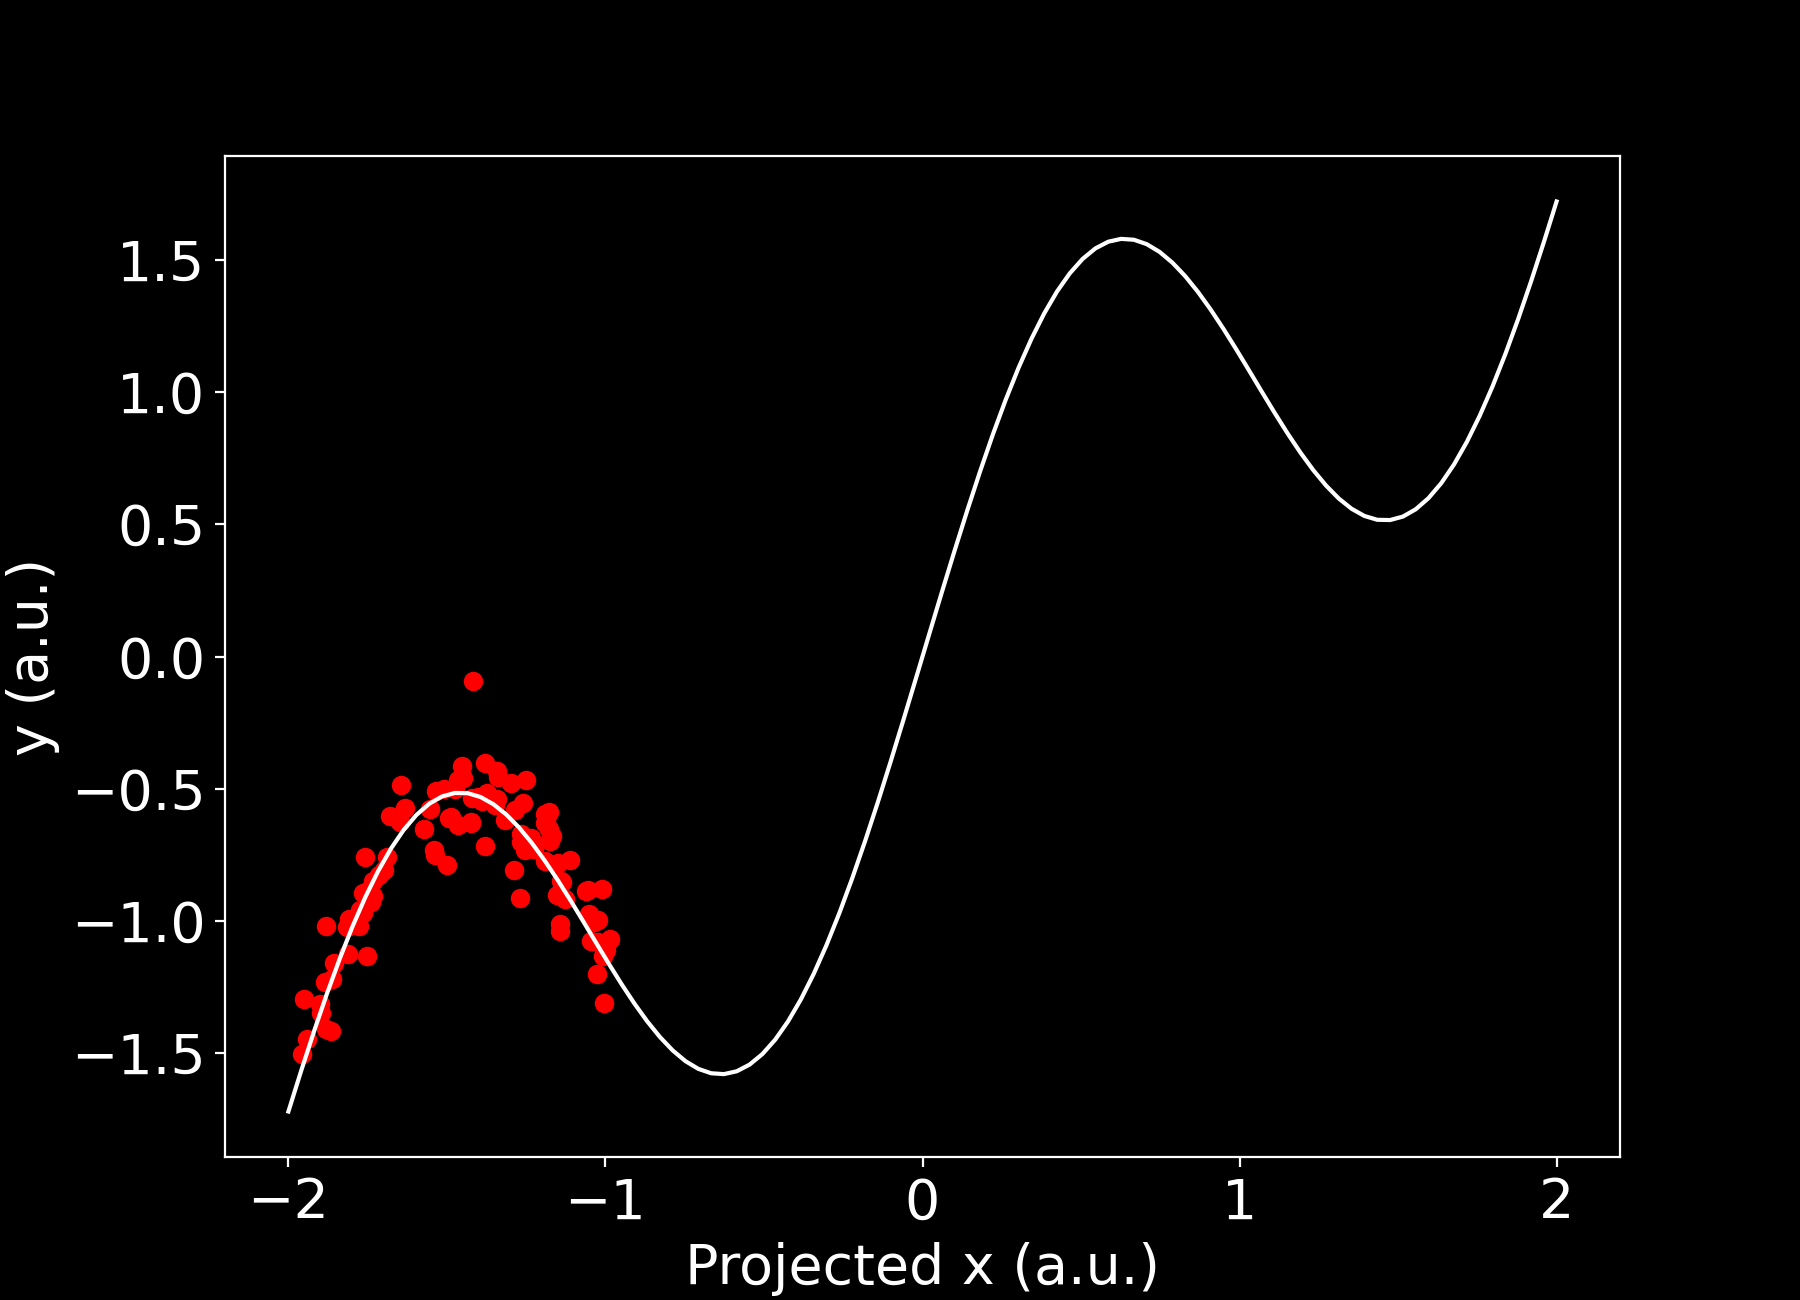

Text(0, 0.5, 'y (a.u.)')

In [272]:
plt.figure(figsize=(9, 6.5))
plt.plot(ex_proj_x_vls, ex_y_vls, 'ro')
plt.plot(f_x_vls, true_f_vls, color='w')
plt.xlabel('Projected x (a.u.)')
plt.ylabel('y (a.u.)')

### Plot the true low-d function and the predictions from the example individual

In [293]:
fit_type = 'comb'  # 'comb' or 'single'
exam_type = 'ip'

In [294]:
if fit_type == 'single':
    fit_rs = single_fit_rs
else:
    fit_rs = comb_fit_rs

if exam_type == 'sp':
    exam_priors = fit_rs['sp']['priors']
    exam_posts = [coll.posteriors for coll in fit_rs['sp']['vi_collections']]
    exam_vi_collections = fit_rs['sp']['vi_collections']
    exam_mdls = [coll.mdl for coll in fit_rs['sp']['vi_collections']]
    exam_logs = fit_rs['sp']['logs']
else:
    exam_priors = fit_rs['ip']['priors']
    exam_posts = [coll.posteriors for coll in fit_rs['ip']['vi_collections']]
    exam_vi_collections = fit_rs['ip']['vi_collections']
    exam_mdls = [coll.mdl for coll in fit_rs['ip']['vi_collections']]
    exam_logs = fit_rs['ip']['logs']

In [295]:
exam_w = exam_posts[ex_ind].w_post(ind_props[ex_ind])
exam_s_in = exam_posts[ex_ind].s_in_post(ind_props[ex_ind]).squeeze(axis=1)
exam_b_in = exam_posts[ex_ind].b_in_post(ind_props[ex_ind]).squeeze(axis=1)
exam_s_out = exam_posts[ex_ind].s_out_post(ind_props[ex_ind]).squeeze(axis=1)
exam_b_out = exam_posts[ex_ind].b_out_post(ind_props[ex_ind]).squeeze(axis=1)
exam_psi = exam_posts[ex_ind].psi_post.dists[0].mode(ind_props[ex_ind]).squeeze(axis=1)

In [296]:
n_exam_smps = 1000

In [297]:
x_exam = torch.tensor(sample_proj_data_from_interval(n_smps=n_exam_smps, 
                                                      w=ind_true_mdls[ex_ind].w.detach().numpy(), 
                                                      interval=[intervals[0], intervals[-1]]),
                       dtype=torch.float)

In [298]:
align_vls = align_low_d_spaces(w_0=ind_true_mdls[ex_ind].w.detach().numpy(),
                               s_in_0=ind_true_mdls[ex_ind].s_in.detach().numpy(),
                               b_in_0=ind_true_mdls[ex_ind].b_in.detach().numpy(),
                               w_1=exam_w.detach().numpy(),
                               s_in_1=exam_s_in.detach().numpy(),
                               b_in_1=exam_b_in.detach().numpy(),
                               z_1=x_pred_proj.numpy())

x_pred_proj_aligned = align_vls[-1]

In [299]:
with torch.no_grad():
    
    # Determine which of our test points are in and out of the training distribution for this individual 
    x_true_proj = ind_true_mdls[ex_ind].project(x_exam).numpy()
    x_true_proj_for_int = ind_true_mdls[ex_ind].project(x_exam, apply_scales_and_biases=False).numpy().squeeze()
    
    x_within_train_dist = np.logical_and(x_true_proj_for_int >= intervals[ex_ind], 
                                         x_true_proj_for_int < intervals[ex_ind+1])
    x_outside_train_dist = np.logical_not(x_within_train_dist)
    
    # Get true mean and predicted mean for each data point for this individual 
    true_mns = ind_true_mdls[ex_ind].m(ind_true_mdls[ex_ind].project(x_exam)).numpy()
    pred_mns = exam_mdls[ex_ind].cond_mean(x=x_exam, w=exam_w, s_in=exam_s_in, b_in=exam_b_in, 
                                             s_out=exam_s_out, b_out=exam_b_out)
    x_pred_proj = exam_mdls[ex_ind].project(x=x_exam, w=exam_w, s_in=exam_s_in, b_in=exam_b_in)

<IPython.core.display.Javascript object>


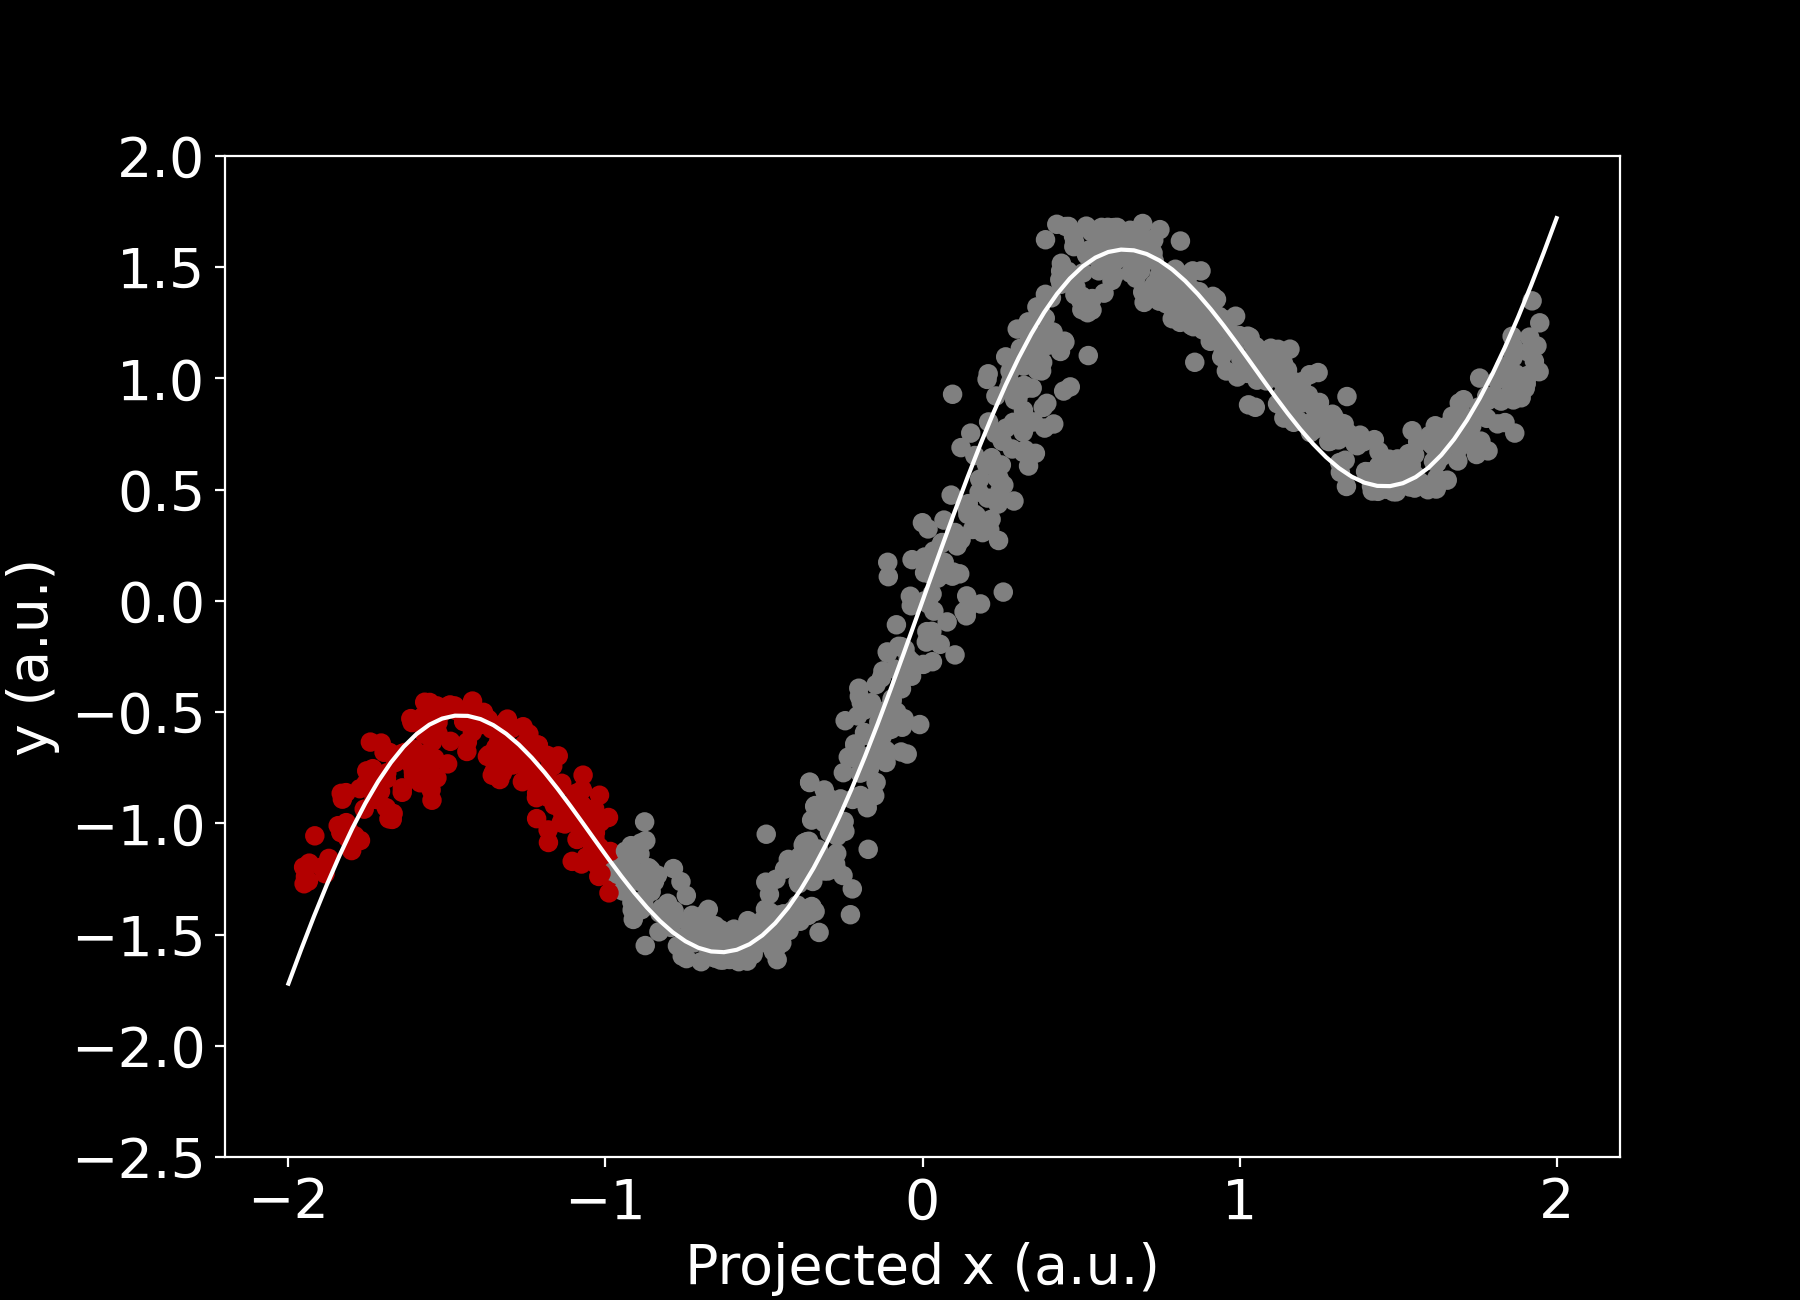

Text(0, 0.5, 'y (a.u.)')

In [300]:
true_clrs = np.zeros([n_exam_smps,4])
true_clrs[:,-1] = 1.0
true_clrs[x_outside_train_dist, 0] = 1.0

pred_clrs = np.zeros([n_exam_smps,4])
pred_clrs[:, -1] = 1.0
pred_clrs[x_outside_train_dist, 0:3] = .5
#pred_clrs[x_outside_train_dist, -1] = 0 
pred_clrs[np.logical_not(x_outside_train_dist), 0] = .7


plt.figure(figsize=(9, 6.5))
a = plt.subplot(1,1,1)
a.scatter(x_true_proj, pred_mns, color=pred_clrs)
plt.ylim([-2.5, 2])

plt.plot(f_x_vls, true_f_vls, color='w')
plt.xlabel('Projected x (a.u.)')
plt.ylabel('y (a.u.)')


### Plot the learned priors

In [327]:
pred_w_mn

array([[-0.11706279],
       [-0.11706279],
       [-0.18139093],
       ...,
       [-0.5838899 ],
       [-0.427416  ],
       [-0.427416  ]], dtype=float32)

In [336]:
pred_w_mn = exam_priors.w_prior(pts).detach().cpu().numpy()
pred_w_std = np.concatenate([d.std_f(pts).detach().cpu().numpy() for d in exam_priors.w_prior.dists], axis=1)

true_w_mn = true_priors.w_prior(pts).detach().cpu().numpy()

pred_mn_supp = np.concatenate([pred_w_mn, np.ones([pred_w_mn.shape[0], 1])], axis=1)
t = numpy.linalg.lstsq(pred_mn_supp, true_w_mn, rcond=None)
t = t[0]
pred_mn_al = np.matmul(pred_mn_supp, t)
pred_mn_al = pred_mn_al.reshape([100,100]).transpose()


t_std = t[0]
pred_w_std_al = np.zeros(pred_w_std.shape)
for i, std_i in enumerate(pred_w_std):
    pred_w_std_al[i, :] = np.abs(t_std)*std_i
pred_w_std_al = pred_w_std_al.reshape([100,100]).transpose()

<IPython.core.display.Javascript object>


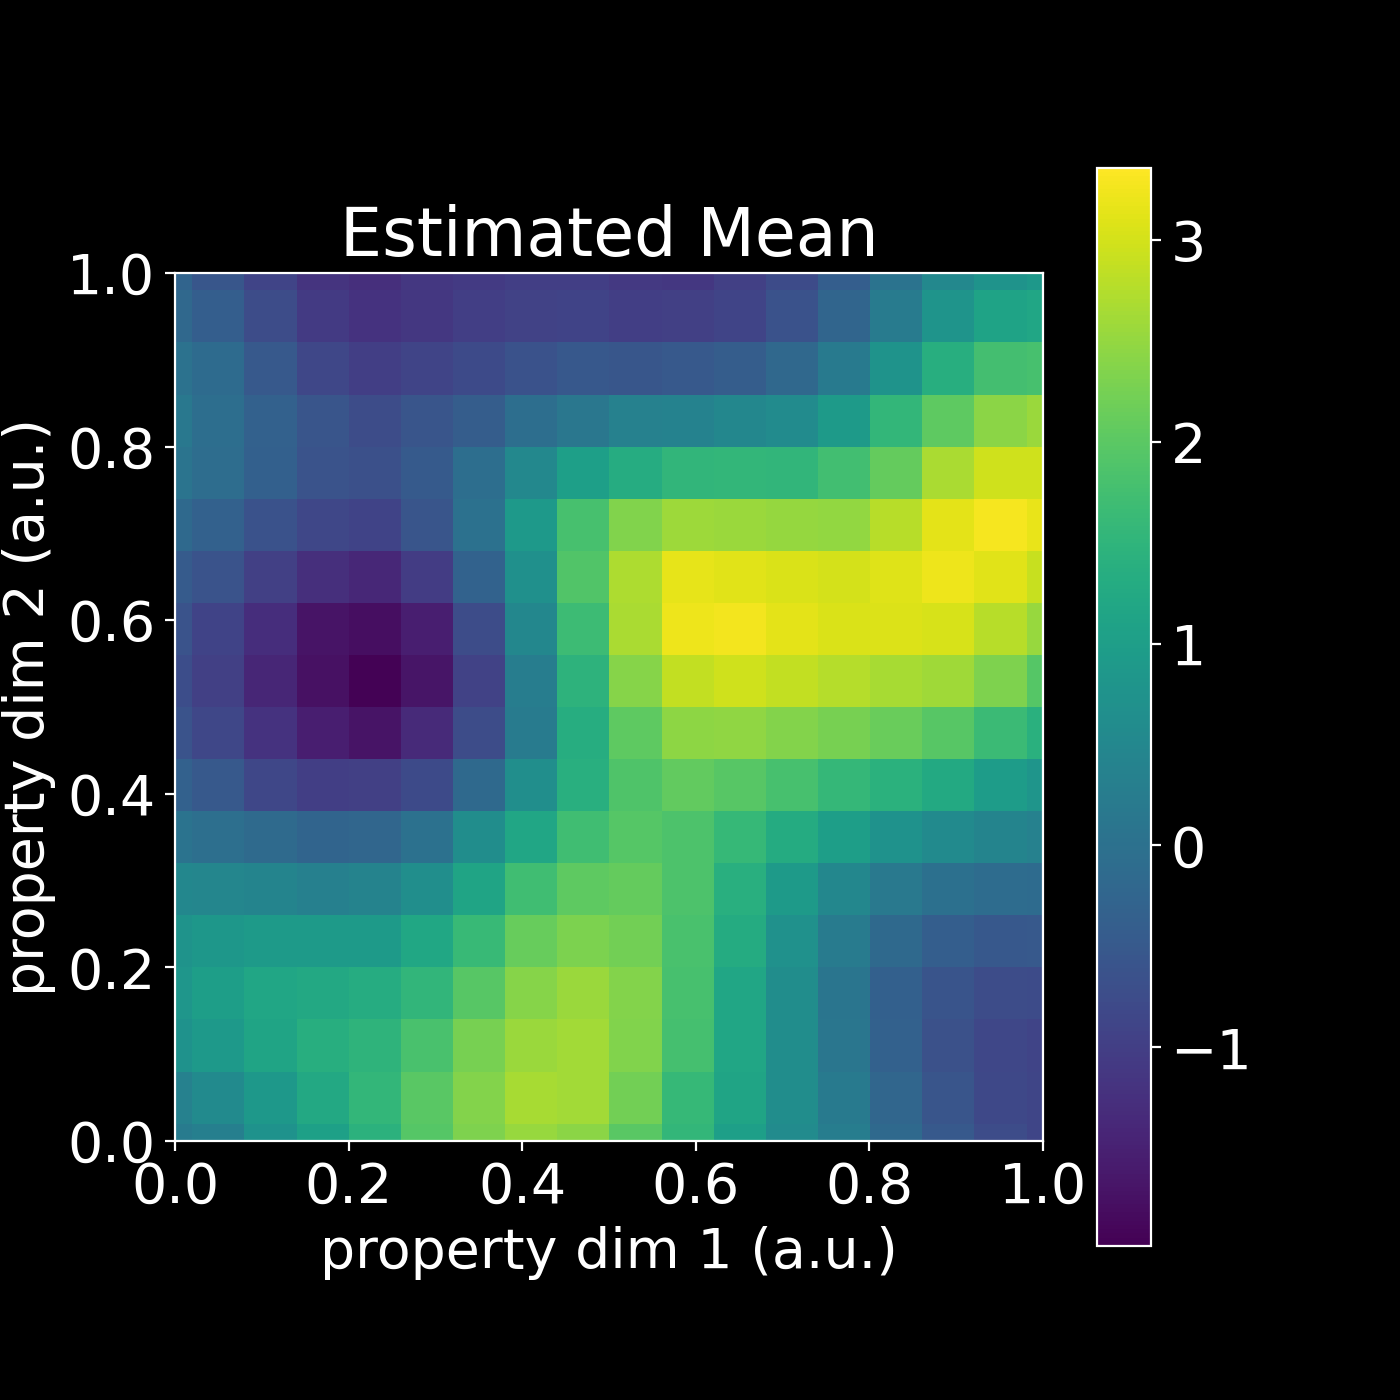

<IPython.core.display.Javascript object>


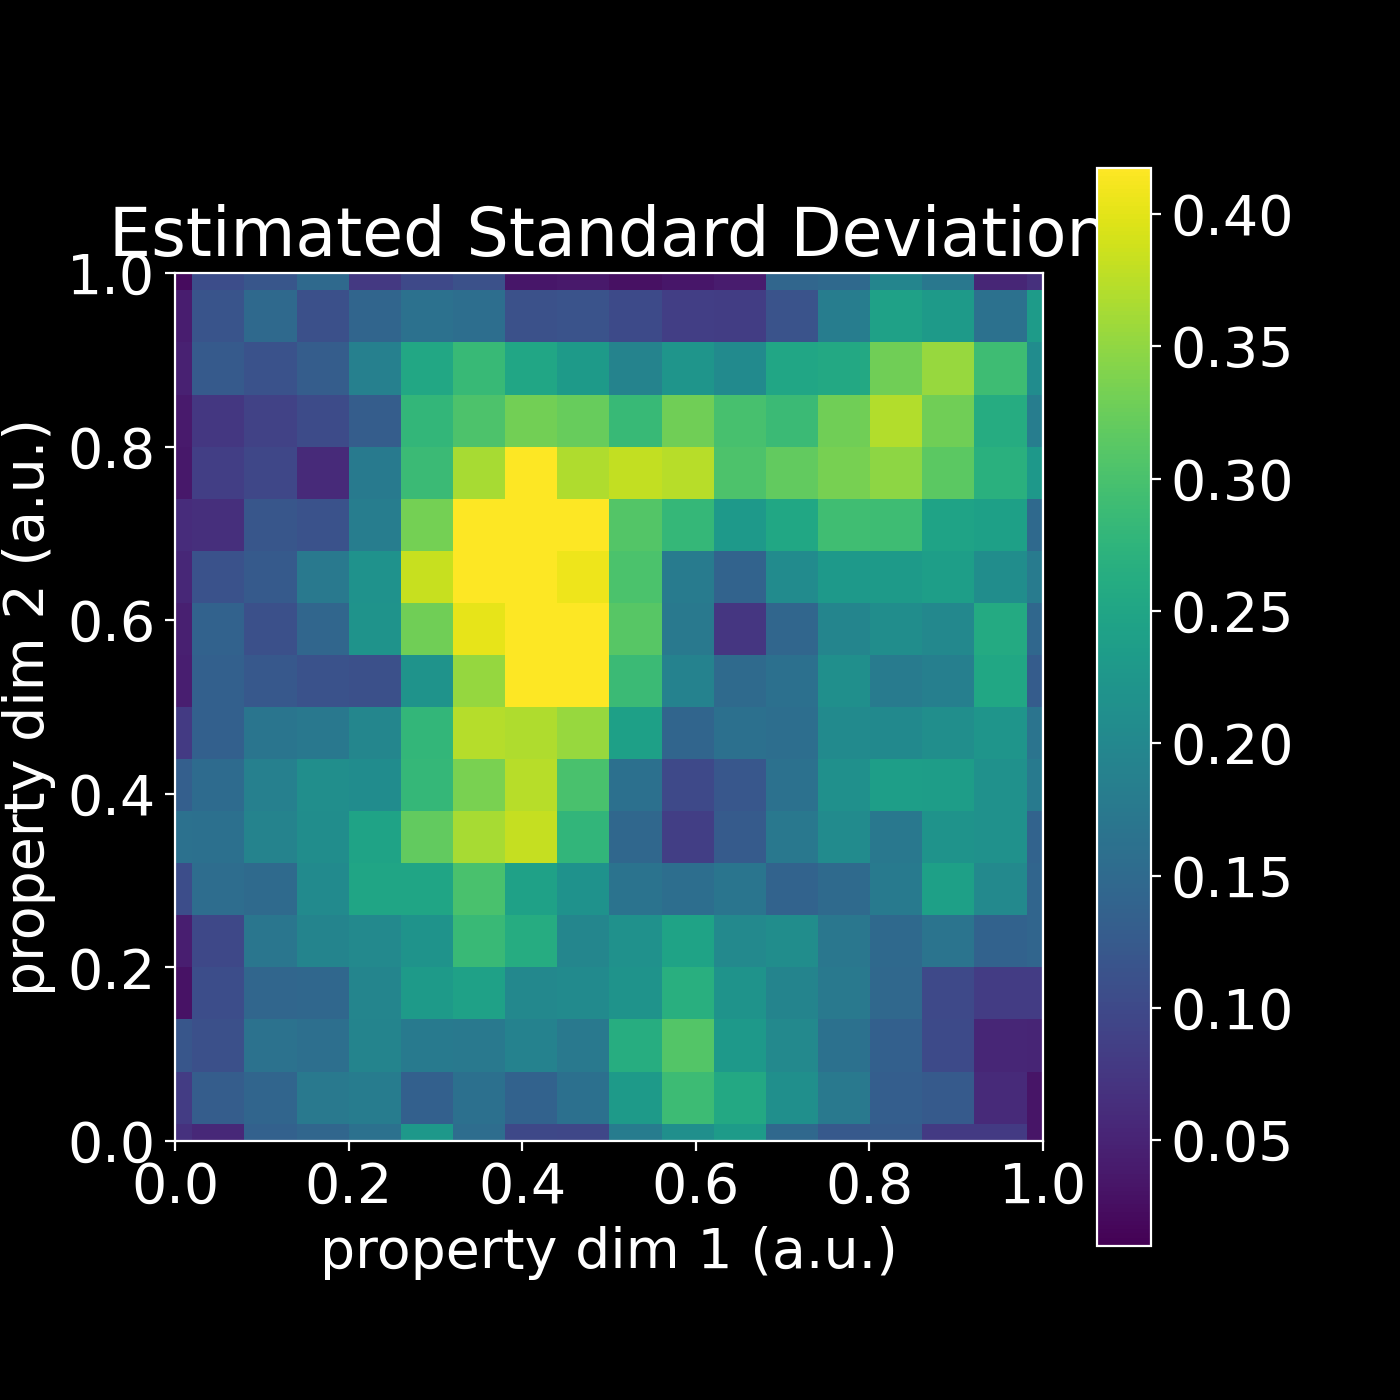

Text(0.5, 1.0, 'Estimated Standard Deviation')

In [338]:
plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(pred_mn_al, origin='lower', extent=[0, 1.0, 0, 1.0], vmin=mn_vmin, vmax=mn_vmax)
plt.colorbar(im)
format_box(ax)
plt.title('Estimated Mean')

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(pred_w_std_al, origin='lower', extent=[0, 1.0, 0, 1.0], vmin=std_vmin, vmax=std_vmax)
plt.colorbar(im)
format_box(ax)
plt.title('Estimated Standard Deviation')


## Look at fitting logs

<IPython.core.display.Javascript object>


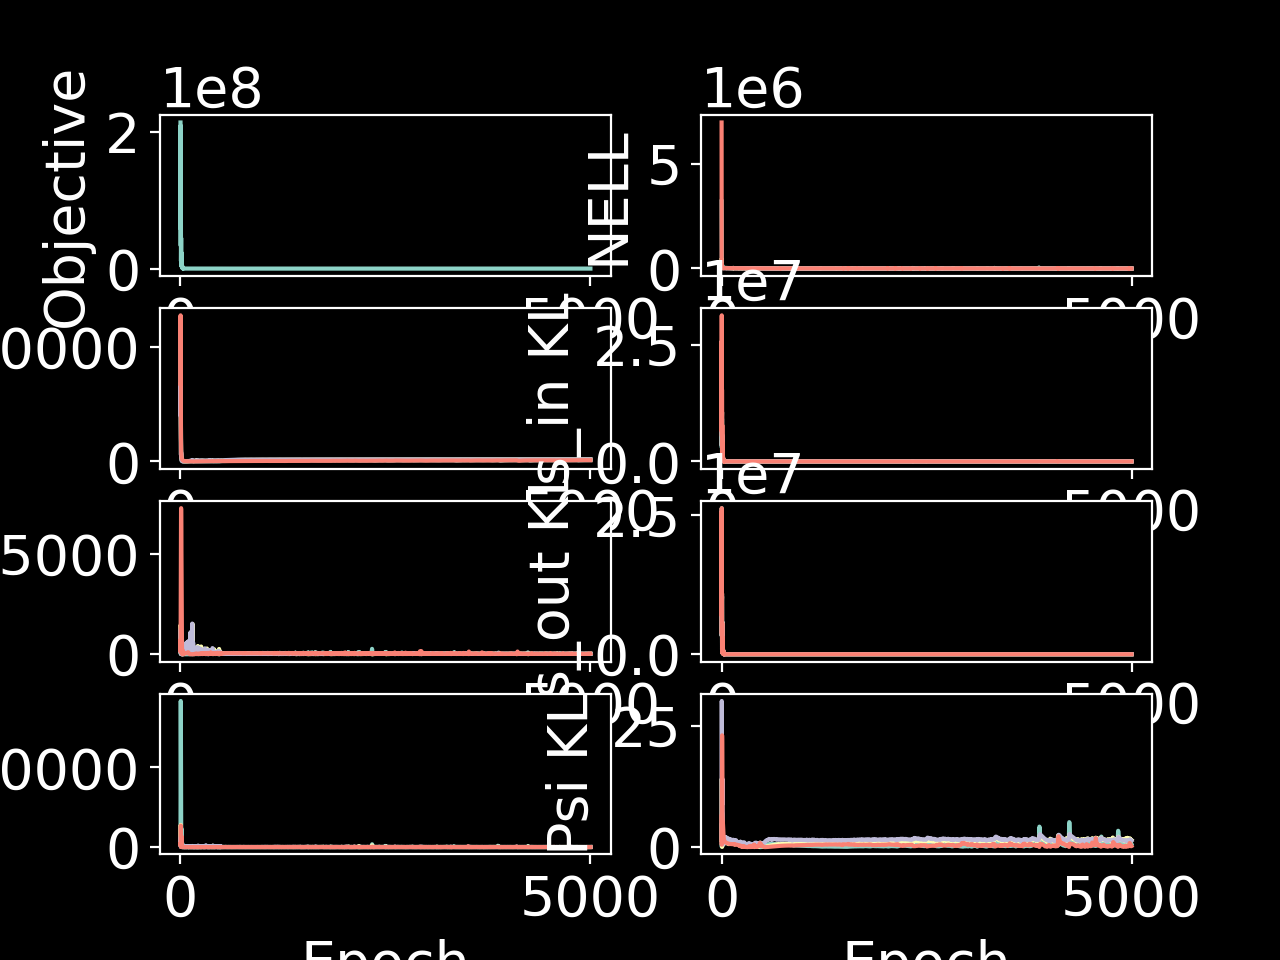

In [154]:
for log in exam_logs:
    Fitter.plot_log(log)

## Look at individual model parameters

<IPython.core.display.Javascript object>


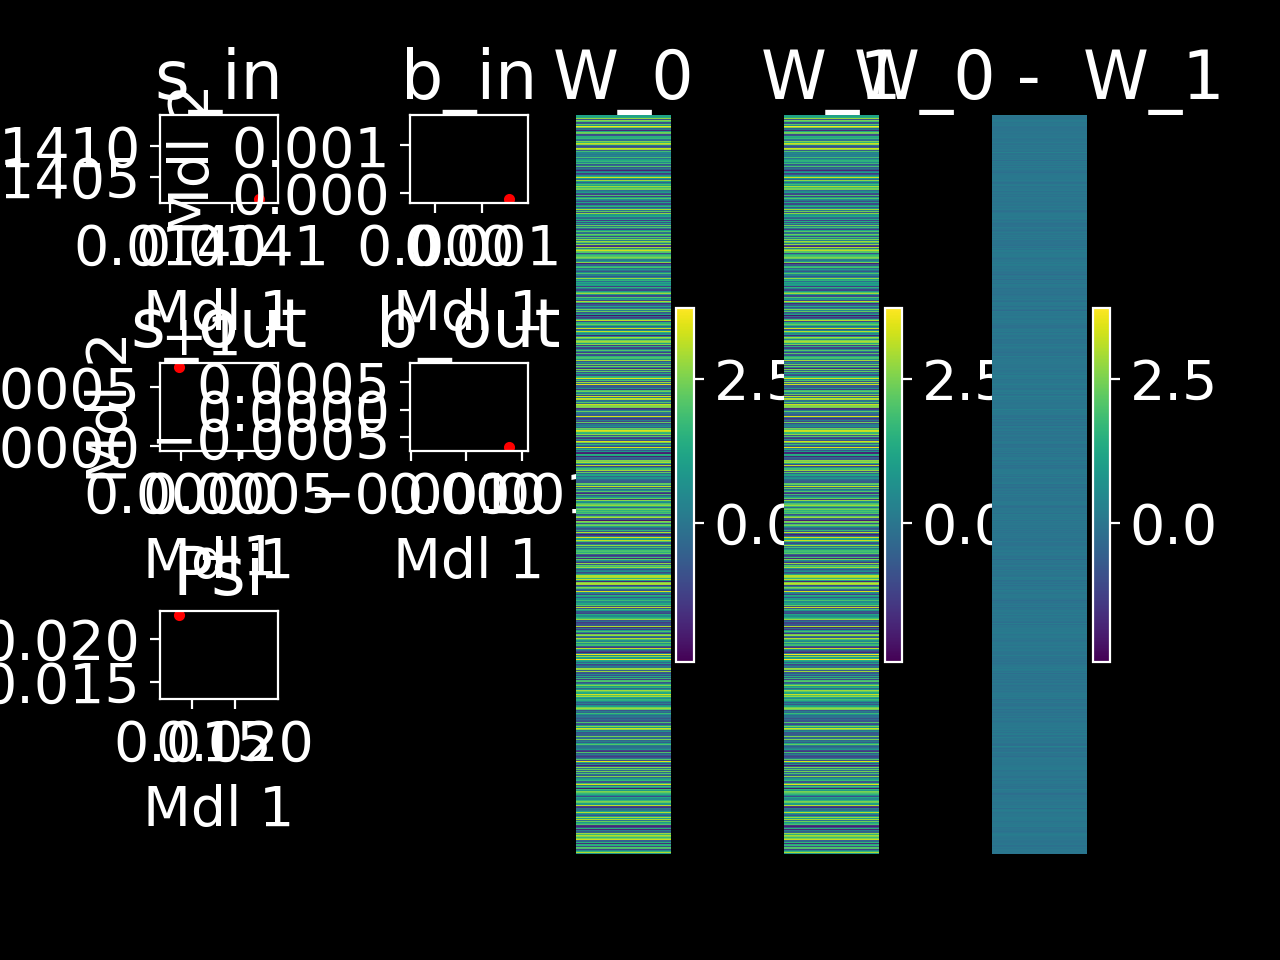

[[-1.3354155]]


In [260]:
exam_mdl = GNLRMdl(m = exam_vi_collections[ex_ind].mdl.m, w=exam_w, s_in=exam_s_in, b_in=exam_b_in, 
                  s_out=exam_s_out, b_out=exam_b_out, psi=exam_psi)

plt.figure()
GNLRMdl.compare_mdls(ind_true_mdls[exam_ind], exam_mdl)

### Plot some random white noise

In [283]:
n_white_noise_pts = 50
n_white_noise_vars = 1

noise = np.random.randn(n_white_noise_pts, n_white_noise_vars)
for i in range(n_white_noise_vars):
    noise[:, i] += i*4

<IPython.core.display.Javascript object>


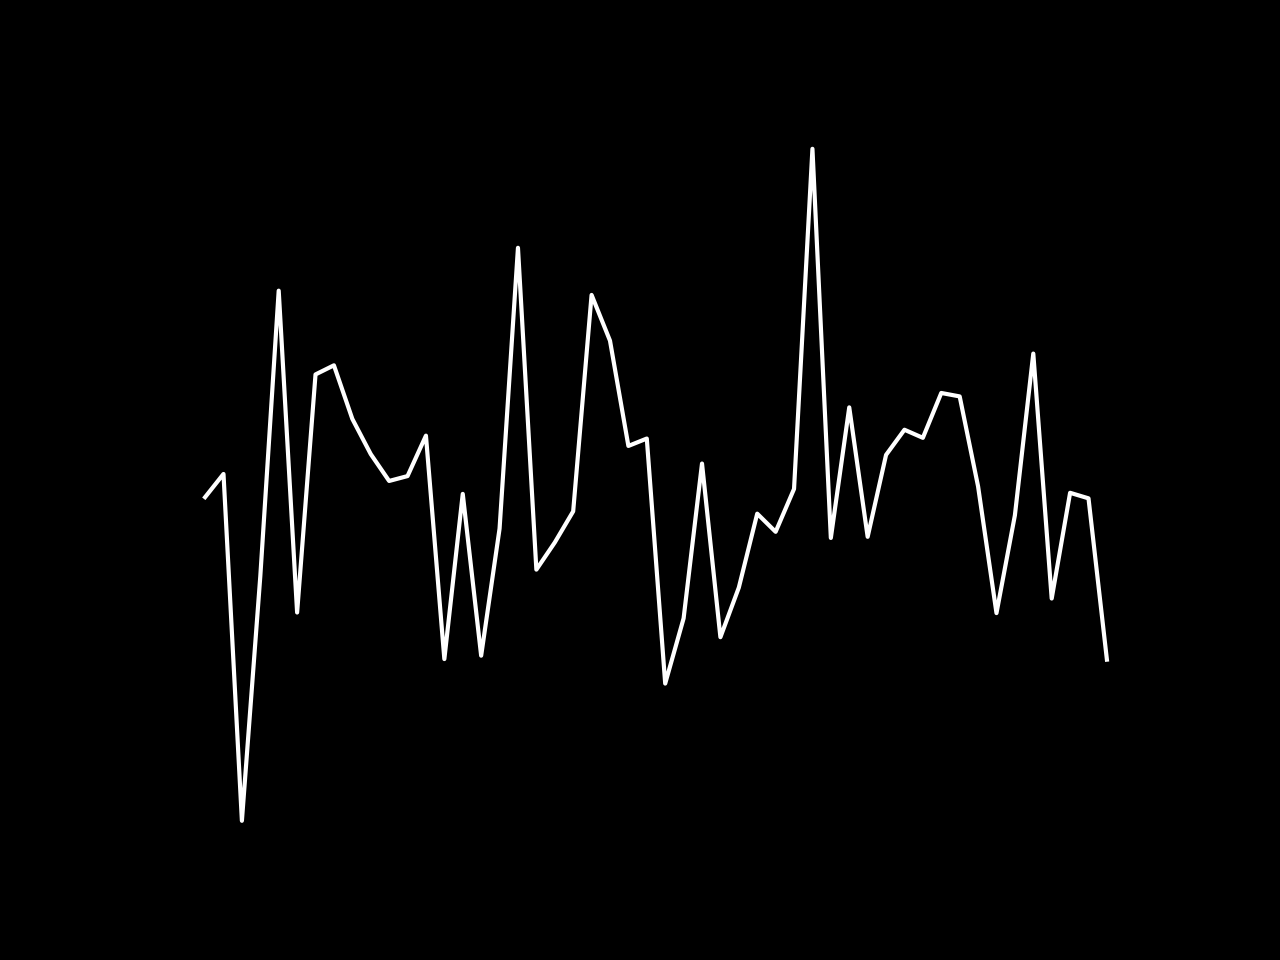

(-2.45, 51.45, -2.527455011215646, 2.6820051803545257)

In [284]:
plt.figure()
for i in range(n_white_noise_vars):
    plt.plot(noise[:, i], 'w-')
    
plt.axis('off')